### Introduction

This notebook is based on the python file that we would use to make the time series logic for regression test.

In [54]:
import pandas as pd
import numpy as np
import copy
import os
import matplotlib.pyplot as plt
import pylab as pl
from datetime import datetime

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# these modules are used for statistics for time series
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

import warnings

warnings.simplefilter('ignore')

In [4]:
path_arima = "C:/Users/guangqiiang.lu/Downloads/model-asset/arima"

In [5]:
# first let to load data
data_np = np.load(os.path.join(path_arima, 'model_data.npy'), allow_pickle=True)

data_column = ['Supplier Name              ', 'Supplier Num', 'Supplier Type',
               'Supplier Site', 'Operating Unit', 'Invoice Date', 'Invoice Number',
               'Invoice Amount', 'Invoice Currency', 'Discount Amount',
               'Payment Amount', 'Payment Currency', 'Payment Document Name',
               'Payment Method', 'Pay Group', 'Document Number', 'Payment Date',
               'FileName', 'Company Code', 'Exchange Rate', 'invoice Exchange Rate',
               'Payment AmountUSD', 'invoice AmountUSD', 'Vendor Category',
               'Trade Type', 'Month end day', 'Scope', 'DTP', 'Weighted DTP Value',
               'KeyMaster', 'Working Capital Impact', 'Pay Term', 'Invoice Type',
               'Net Due Date', 'Aging', 'Payment Category', 'Weighted Aging Value',
               'Payment Term Days', 'P&L Impact', 'Late Pay Range']

data = pd.DataFrame(data_np, columns=data_column)

data.head()

,Supplier Name,Supplier Num,Supplier Type,Supplier Site,Operating Unit,Invoice Date,Invoice Number,Invoice Amount,Invoice Currency,Discount Amount,...,Working Capital Impact,Pay Term,Invoice Type,Net Due Date,Aging,Payment Category,Weighted Aging Value,Payment Term Days,P&L Impact,Late Pay Range
0,bingologistics (shanghai）Co. Ltd.,10826,NONTRADE,CNCNYNTRCN1A,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-11-08,07000677-07000679,235090,CNY,0,...,35610,NET_45,STANDARD,2017-12-23,-30,Early Payment,-1.0683e+06,45,-234.148,<10%
1,"shanghai aiconb Technology Co., Ltd.",10902,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-06-08,5093620,6450,CNY,0,...,951.201,NET_45,STANDARD,2017-07-23,-31,Early Payment,-29487.2,45,-6.46296,<10%
2,shouxiafeng,10815,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-04-06,14378087,25000,CNY,0,...,3686.83,NET_45,STANDARD,2017-05-21,32,Late Payment,117978,45,25.8583,50%+
3,shouxiafeng,10815,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-10-10,14378100,25000,CNY,0,...,3842.13,NET_45,STANDARD,2017-11-24,27,Late Payment,103738,45,22.737,50%+
4,wanda jiecheng International Logistics (Beijin...,10800,NONTRADE,CNCNYNTRCN1,"ARROW(CHINA)ELECTRONICSTRADINGCO.,LTD.",2017-12-05,18354393,66495.1,CNY,0,...,10219.3,NET_45,STANDARD,2018-01-19,-29,Early Payment,-296360,45,-64.9557,<10%


In [7]:
# you could see that there are 4 millions records.
print("how many data: ", data.shape)

how many data:  (407575, 40)


In [8]:
filter_date = input("please input the train start date(yyyy-mm-dd):")


please input the train start date(yyyy-mm-dd):2018-01-01


In [9]:
# convert to date type
data['Payment Date'] = pd.to_datetime(data['Payment Date'])
# convert to float type
data['Payment AmountUSD'] = data['Payment AmountUSD'].astype(float)

# just get data greater than filter date
data_filter = data[data['Payment Date']>=filter_date]

# there are 322392 records.
data_filter.shape

(322392, 40)

In [10]:
# according to Payment date to sum of the target value
data_new = data_filter.groupby('Payment Date',as_index = False)['Payment AmountUSD'].sum()
# reset the columns name
data_new.columns = ['Month','Amount']

# that's means there are 406 days.
print("How many dates: ", data_new.shape)

data_new.head()


How many dates:  (406, 2)


,Month,Amount
0,2018-01-02,1.964215e+06
1,2018-01-03,2.755046e+05
2,2018-01-05,3.514239e+06
3,2018-01-11,4.700004e+06
4,2018-01-12,4.862683e+05


In [12]:
# there is a file mapping called:C://Users/fang.jia/Desktop/Project/Arrow/Model 5/节假日mapping.xlsx
# I don't find that mapping file, but there is a mapping file in xgboost, so I just use this file.
mapping_path = "C:/Users/guangqiiang.lu/Downloads/model-asset/xgboost"

mapping_file = [x for x in os.listdir(mapping_path) if 'mapping' in x.lower()][0]

# load mapping file
mapping = pd.read_excel(os.path.join(mapping_path, mapping_file), encoding='utf-8')

mapping.head()

,date,weekday,holiday,day after vacation,day after vacation days,special vacation,quarter,month of quarter,week of month
0,2017-01-01,7,1,0,0,0,1,1,1
1,2017-01-02,1,1,0,0,0,1,1,1
2,2017-01-03,2,0,1,2,1,1,1,1
3,2017-01-04,3,0,0,0,0,1,1,1
4,2017-01-05,4,0,0,0,0,1,1,1


In [13]:
# just get mapping date
mapping_new = mapping['date']
# reset index
mapping_new = mapping_new.reset_index(name = 'date')

# rename columns
mapping_new.columns = ['index','Month']

print("How many mapping records:", mapping_new.shape)

mapping_new.head()


How many mapping records: (1461, 2)


,index,Month
0,0,2017-01-01
1,1,2017-01-02
2,2,2017-01-03
3,3,2017-01-04
4,4,2017-01-05


In [15]:
# get min and max date
min_date = data_new['Month'].min()
max_date = data_new['Month'].max()

print('Min date: {}, max date: {}'.format(min_date, max_date))

Min date: 2018-01-02 00:00:00, max date: 2020-04-28 00:00:00


In [18]:
# let's merge mapping and date_new according to month column infact is `date`
rawdata_fin = mapping_new.merge(data_new,how = 'left',on = ['Month'])

# in case there are any date with NAN, just fillin with 0, 
#### Noted: As there is one step that wants to check the missing value ratio, if just fillna(0), there won't be any missing value.
rawdata_f = rawdata_fin[['Month','Amount']].fillna(0)

# this is to ensure that the new data should satisfy date should upper than min_date and lower than max_date
# as maybe mapping date has more date than rawdata
rawdata = rawdata_f[(rawdata_f['Month']>=min_date)&(rawdata_f['Month']<=max_date)]

# so that you could see that there are more date in mapping.
print("Mapping_new shape:", mapping_new.shape)
print("Raw date shape:", rawdata.shape)
rawdata.head()

Mapping_new shape: (1461, 2)
Raw date shape: (848, 2)


,Month,Amount
366,2018-01-02,1.964215e+06
367,2018-01-03,2.755046e+05
368,2018-01-04,0.000000e+00
369,2018-01-05,3.514239e+06
370,2018-01-06,0.000000e+00


#### 模型前数据处理处理——缺失值处理
统计缺失值数量

Missing records:     index  missNum
0   Month        0
1  Amount        0
Missing order: Empty DataFrame
Columns: [index, missNum, missRate]
Index: []


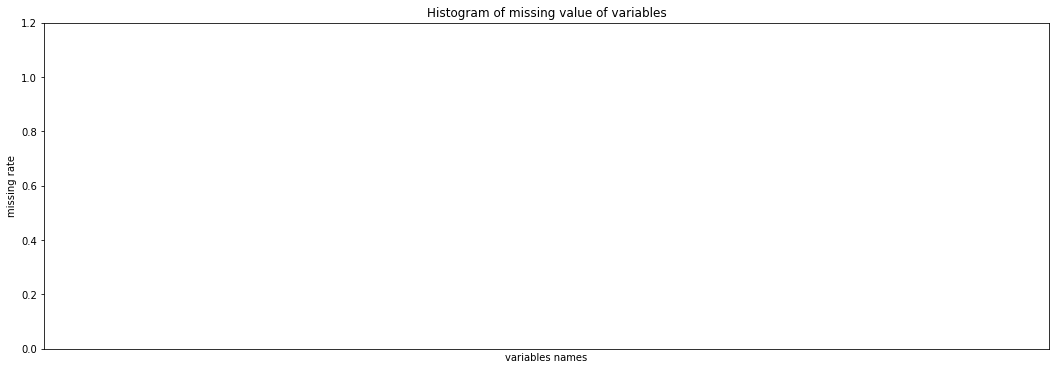

In [25]:
# this is to check how many records are nan
missing=rawdata.isnull().sum().reset_index().rename(columns={0:'missNum'})

# you could see that there isn't any missing value for each column, as both are 0
print("Missing records:", missing.head())

#计算缺失比例
missing['missRate']=missing['missNum']/data.shape[0]

#按照缺失率排序显示
miss_analy=missing[missing.missRate>0].sort_values(by='missRate',ascending=False)

# empty dataframe
print("Missing order:", miss_analy.head())

#用图形展示缺失值情况
fig = plt.figure(figsize=(18,6))
plt.bar(np.arange(miss_analy.shape[0]), list(miss_analy.missRate.values), align = 'center',color=['red','green','yellow','steelblue'])
plt.title('Histogram of missing value of variables')
plt.xlabel('variables names')
plt.ylabel('missing rate')

# 添加x轴标签，并旋转90度
plt.xticks(np.arange(miss_analy.shape[0]),list(miss_analy['index']))
pl.xticks(rotation=90)

# 添加数值显示
for x,y in enumerate(list(miss_analy.missRate.values)):
    plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
plt.ylim([0,1.2]) 
plt.show()

In [26]:
#去掉缺失比例大于80%以上的变量——人工判断
rawdata=rawdata.dropna(thresh=len(rawdata)*0.2, axis=1)

### Missing data imputation with KNN

If there are some missing values in each columns, there are some ways that we could take to process the missing value, like `mean value`, `most frequent value`, `algorithm based imputation` etc. means that we could use some algorithms to impute the missing value to do the prediction for missing value based on non-missing value data, logic is: get non-missing data, use these data to fit model, then do prediction on those missing features.

In [27]:
# this is to construct model based on missing columns
def knn_filled(key,x_train, y_train, test_x, k = 3, dispersed = True):
    if dispersed:
        clf = KNeighborsClassifier(n_neighbors = k, weights = "distance")
    else:
        clf = KNeighborsRegressor(n_neighbors = k, weights = "distance")    
    clf.fit(x_train, y_train)
    test_y = clf.predict(test_x)
    (x,y) = x_train.append(test_x),y_train.append(test_y)
    data = pd.concat(key,x,y)
    return data

In [32]:
#使用定义的knn对数据进行补充
imputed_data = pd.DataFrame()

# this is to get the keys that are nan
selected_q = rawdata[rawdata['Month'].isna()]['Month']

# so currently there isn't any missing value.
print("the null date: ", selected_q)

for i in selected_q:
    i_1 = rawdata[rawdata['Month'] == i]
    Cos_impute = knn_filled(i,i_1['Month'][i_1['Amount'].notna()],i_1['Amount'][i_1['Amount'].notna()],i_1['Month'][i_1['Amount'].isna()],k = 5,dispersed = False)
    imputed_data = imputed_data.append(Cos_impute)

the null date:  Series([], Name: Month, dtype: datetime64[ns])


In [36]:
# this for time series training data start date
start = input('input the test start date(yyyy-mm-dd):')
end = input('input the test end date(yyyy-mm-dd):')

input the test start date(yyyy-mm-dd):2019-01-01
input the test end date(yyyy-mm-dd):2020-01-01


In [37]:
#时间序列数据处理
#时间索引  
Model_data = copy.copy(rawdata)

# set index as month
Model_data.set_index(["Month"], inplace=True)

# set month index as date
Model_data.index = pd.to_datetime(Model_data.index)

# get time series data above start
ts_data = Model_data[Model_data.index < start]

print("Model data shape", Model_data.shape)
print("TS data shape:", ts_data.shape)

Model data shape (848, 1)
TS data shape: (364, 1)


##### adfuller 

this is a test to check whether or not the data is series correlation, you could just keep in mind is to check whether or not the target is series correlation, you could check it [here](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html).

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root(单位根检验), with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root.

In [38]:
#通过p值判断是否稳定
p = adfuller(ts_data['Amount'])[1]
print('p value:', p)

p value: 0.005727993167434378


In [50]:
#对不平稳的数据进行数据平滑
time_series_diff = ts_data['Amount']
diff_times = 10
first_values = []

# this is to check 10 days.
# in fact currently p is less than 0.05, so it just stop with one time
for i in range(1, diff_times+1):
    if p>0.05:
        first_values.append(pd.Series([time_series_diff[0]],index=[time_series_diff.index[0]]))
        # this is to move the data from day1 to day2: like a=[1, 2, 3], diff(1) will be [nan, 1, 2]
        time_series_diff = time_series_diff.diff(1).dropna()
        # this is to check the next n-day's is series correlation or not, if true, we could check next day
        p = adfuller(time_series_diff)[1]
    else:
        diff_times = i - 1
        break
        
print(first_values)

[]


###### Ljung-Box test

Ljung-Box test of autocorrelation in residuals, just to check whether or not could do time series, you could find some detail [explain](https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.acorr_ljungbox.html).

In [52]:
model_data = copy.copy(time_series_diff)
#白噪声检验——差分到数据平稳后p>0.05,未通过白噪声检验，不适合做时间序列
p_ts = min(acorr_ljungbox(model_data)[1])

# so this data could use time series
print(p_ts)
print(p_ts<0.05)

5.419660908022273e-21
True


In [55]:
#数据平稳后，需要对模型定阶，即确定p、q的阶数
# AIC is a metric that we could use to find best p and q value
AIC = sm.tsa.arma_order_select_ic(model_data,max_ar=6,max_ma=4,ic='aic')['aic_min_order']  # AIC
p = AIC[0]
q = AIC[1]

print("best p:{}, best q:{}".format(p, q))

best p:2, best q:2


In [57]:
# let's make it into a dataframe, you could do these steps, or you couldn't do that, don't affact the logic, 
# just to check the best value and best diff_times with p_value
# first to make it into a dictionary
p_dict = {'p_value':p_ts,'diff_times':diff_times,'p':p,'q':q}

# create dataframe from dictionary
p_value = pd.DataFrame.from_dict(p_dict,orient='index').T

p_value.head()

,p_value,diff_times,p,q
0,5.419661e-21,0.0,2.0,2.0


In [59]:
# alright, we have done preprocessing step, now we could start our training step
# get how many satisfy data according month between start and end date.
length = len(mapping_new['Month'][(mapping_new['Month']>=start)&(mapping_new['Month']<=end)].tolist())

# this is to construct the model based on best p and q value
model = ARMA(model_data, order=(p,q)) 
# model training
result_arima = model.fit()

# get prediction on training data from start date to end date.
predict_ts = result_arima.forecast(length)[0]

print(predict_ts[:5])

[ 983842.10711891 2713736.68375665 3587861.58355446 2947691.34671377
 1276124.81966427]


In [61]:
first_values

[]

In [62]:
#多次差分及差分还原
# as maybe we have used some residual in training, currently doesn't use any residuals
# if so we could do cumulative sum
time_series_restored = predict_ts
for first in reversed(first_values):
    time_series_restored = first.append(time_series_restored).cumsum()

print(time_series_restored[:5])

[ 983842.10711891 2713736.68375665 3587861.58355446 2947691.34671377
 1276124.81966427]


In [63]:
#查看模型准确率
forecast = pd.DataFrame()
forecast['predict'] = predict_ts

# ensure there isn't any negative value
forecast['predict'] = forecast['predict'].apply(lambda x:0 if x<0 else x)

# ensure the target value is between start and end date
forecast['Month'] = mapping_new['Month'][(mapping_new['Month']>=start)&(mapping_new['Month']<=end)].tolist()

# merge raw data and prediction data.
out_forecast  = pd.merge(rawdata,forecast, how = 'right', on = ['Month'])

# merge mapping file.
out_forecast_mapping = out_forecast.merge(mapping,how = 'left' ,left_on = ['Month'],right_on = ['date'])

# just get some columns that we need to use.
output = out_forecast_mapping[['Month','Amount','predict','quarter','week of month','month of quarter']]

# convert the key to : quarter + month of quarter + week of month
output['key'] = output['quarter'].astype(str)+'-'+output['month of quarter'].astype(str)+'-'+output['week of month'].astype(str)

# let's check.
output.head()

,Month,Amount,predict,quarter,week of month,month of quarter,key
0,2019-01-01,0.000000e+00,9.838421e+05,1,1,1,1-1-1
1,2019-01-02,5.582180e+05,2.713737e+06,1,1,1,1-1-1
2,2019-01-03,7.445970e+06,3.587862e+06,1,1,1,1-1-1
3,2019-01-04,2.966186e+06,2.947691e+06,1,1,1,1-1-1
4,2019-01-05,0.000000e+00,1.276125e+06,1,1,1,1-1-1


In [64]:
choose = input("Whether to include '2020-02'(y/n):")

if choose == "y":
    output_new = output[['key','Month','Amount','predict']]
elif choose =="n":
    output['flag'] = output['Month'].apply(lambda x:x.month)
    output_new = output[['key','Month','Amount','predict']][output['flag']!=2]    
else:print("please input true choose!")

Whether to include '2020-02'(y/n):y


In [65]:
print("Output shape:", output.shape)

Output shape: (366, 7)


In [68]:
# this is to process the output_new dataframe according key
# sum of Amount according to key
output_fin_1 = output_new.groupby('key', as_index = False)['Amount'].sum()

# sum of predict according to key
output_fin_2 = output_new.groupby('key', as_index = False)['predict'].sum()

# merge these two dataframe
output_fin = output_fin_1.merge(output_fin_2,how = 'left',on = 'key')

# compute the accuracy based on 1 - (target - pred) / target
output_fin['accuracy'] = 1-abs(output_fin['Amount']-output_fin['predict'])/output_fin['Amount']


# get accuracy mean score based on Amount not 0
accuracy = output_fin['accuracy'][output_fin['Amount']!=0].mean()

print("accuracy:")
print(accuracy, end='\n')
print("*" * 30)

print("p-value:")
print(p_value, end='\n')
print("*" * 30)

print("output dataframe show:")
print(output_fin.head())

accuracy:
0.5340991781478869
******************************
p-value:
        p_value  diff_times    p    q
0  5.419661e-21         0.0  2.0  2.0
******************************
output dataframe show:
     key        Amount       predict  accuracy
0  1-1-1  1.097037e+07  1.441542e+07  0.685968
1  1-1-2  9.892965e+06  1.150643e+07  0.836907
2  1-1-3  7.696940e+06  1.150358e+07  0.505435
3  1-1-4  2.251476e+07  1.150068e+07  0.510806
4  1-2-1  1.800691e+07  1.149775e+07  0.638519


In [69]:
#模型拟合优度检验
# get training target
train = ts_data[ts_data.index<start]['Amount']
# result_arima.fittedvalues:  this is model training prediction on target 
delta = result_arima.fittedvalues - train    # residual

# score is based on :1 - residual variane/ train variance.
score = 1 - delta.var()/train.var()

print(score)

0.12022219671525303


### Last words

You do could use other metrics to evaluate the model prediction result like `r2-score`, `RMSE` etc. So this is whole logic for ARIMA.